In [1]:
!nvidia-smi

Wed Oct 21 11:57:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:26<00:00, 76.2MB/s]
100% 1.33G/1.33G [00:26<00:00, 54.4MB/s]


In [13]:
!unzip -q celeba-dataset.zip

In [14]:
!rm celeba-dataset.zip

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

In [2]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64

In [3]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=3, expand_animations = False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.image.random_flip_left_right(img)
    return img*2 - 1

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
dataset = tf.data.Dataset.list_files("/content/img_align_celeba/img_align_celeba/*")
dataset = dataset.shuffle(len(dataset))
dataset = dataset.map(load, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

In [6]:
noise_dim = 256

## Using different weight initializer didin't help.

In [7]:
def get_generator():
    inp = layers.Input(shape = (noise_dim,))

    x = layers.Dense(4*4*512, use_bias=False)(inp)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((4,4,512))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2DTranspose(512, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)          # (8, 8, 512)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)          # (16, 16, 256)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)          # (32, 32, 128)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)          # (64, 64, 64)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(x)
                                                            # (128, 128, 3)
    x = layers.Activation('tanh')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    return model

In [8]:
g = get_generator()
g.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
re_lu (ReLU)                 (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)        

## Adding noise to discriminator prolly has best effect and faster training.

In [9]:
def get_discriminator():
    inp = layers.Input(shape=(128,128,3))

    # x = layers.GaussianNoise(0.1)(inp)

    x = layers.Conv2D(32, kernel_size=(4,4), strides=(1,1), padding='same')(inp)
    x = layers.LeakyReLU()(x)                   # (128, 128, 32)
    x = layers.GaussianNoise(0.1)(x)

    x = layers.Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)          # (64, 64, 64)
    x = layers.LeakyReLU()(x)
    x = layers.GaussianNoise(0.1)(x)

    x = layers.Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)          # (32, 32, 128)
    x = layers.LeakyReLU()(x)
    x = layers.GaussianNoise(0.1)(x)

    x = layers.Conv2D(256, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)          # (16, 16, 256)
    x = layers.LeakyReLU()(x)
    x = layers.GaussianNoise(0.1)(x)

    x = layers.Conv2D(512, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)          # (8, 8, 512)
    x = layers.LeakyReLU()(x)
    x = layers.GaussianNoise(0.1)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inp, outputs=x)
    return model

In [10]:
d = get_discriminator()
d.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      1568      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        32768     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)       

In [11]:
criterion = tf.keras.losses.BinaryCrossentropy()

In [12]:
def discriminator_loss(real_output, fake_output):
    # real_loss = criterion(tf.ones_like(real_output), real_output)
    # fake_loss = criterion(tf.zeros_like(fake_output), fake_output)
    # return real_loss + fake_loss
    real_loss = criterion(tf.random.uniform(real_output.shape, minval=0.9, maxval=1), real_output)
    fake_loss = criterion(tf.random.uniform(fake_output.shape, minval=0, maxval=0.1), fake_output)
    return real_loss + fake_loss

In [13]:
def generator_loss(fake_output):
    # return criterion(tf.ones_like(fake_output), fake_output)
    return criterion(tf.random.uniform(fake_output.shape, minval=0.9, maxval=1), fake_output)

In [14]:
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [15]:
import os
from time import time

checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(gen_opt=gen_opt, disc_opt=disc_opt, g=g, d=d)
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)

In [16]:
seed = tf.random.normal([16, noise_dim])

In [17]:
!mkdir timelapse

mkdir: cannot create directory ‘timelapse’: File exists


In [18]:
def gen_grid(gen, show=True, save=False, idx=0):
    fig, ax = plt.subplots(nrows=4,ncols=4,figsize=[16,16],gridspec_kw = {'wspace':0, 'hspace':0})
    fig.patch.set_facecolor('white')
    for i,axi in enumerate(ax.flat):
        axi.axis("off")
        axi.imshow((gen[i]+1)/2)
    if save:
        fig.savefig("./timelapse/"+str(int(time()))+".png", bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = g(noise, training=True)

        real_output = d(images, training=True)
        fake_output = d(generated, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gen_grads = gen_tape.gradient(gen_loss, g.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, d.trainable_variables)

    gen_opt.apply_gradients(zip(gen_grads, g.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grads, d.trainable_variables))
    return gen_loss, disc_loss

In [20]:
!rm timelapse/*

In [21]:
def train(dataset):
    steps = len(dataset)
    start = time()
    i=0
    for batch in dataset:
        gen_loss, disc_loss = train_step(batch)
        if not i%100:
            print(f"\r{i}/{steps}\t Time: {time()-start:.2f}s\t Gen Loss: {gen_loss:.5f}\t Desc Loss: {disc_loss:.5f}", end="    ")
            if not i%1_000:
                noise = tf.random.normal([4, noise_dim])
                gen = g(noise).numpy()
                cnv = np.hstack(gen)
                fig = plt.figure(figsize=[16, 64])
                plt.imshow((cnv+1)/2)
                plt.axis('off')
                plt.show()
                gen = g(seed)
                gen_grid(gen, show=False, save=True, idx=i)
                print("Grid Saved.")
            if not i%7_000:
                manager.save()
                print("Checkpoint saved.")
        i+=1


Epoch 1 of 50.
0/3166	 Time: 4.86s	 Gen Loss: 0.91390	 Desc Loss: 1.46190    

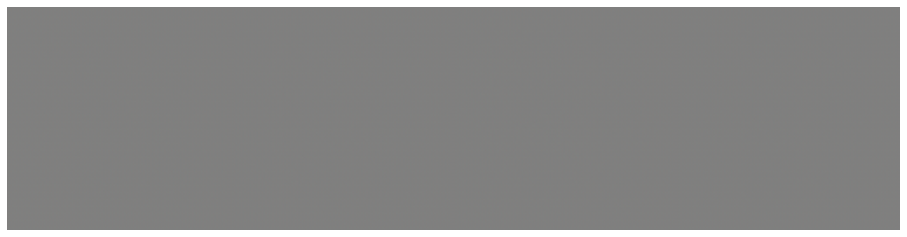

Grid Saved.
Checkpoint saved.
1000/3166	 Time: 175.86s	 Gen Loss: 3.12574	 Desc Loss: 0.70671    

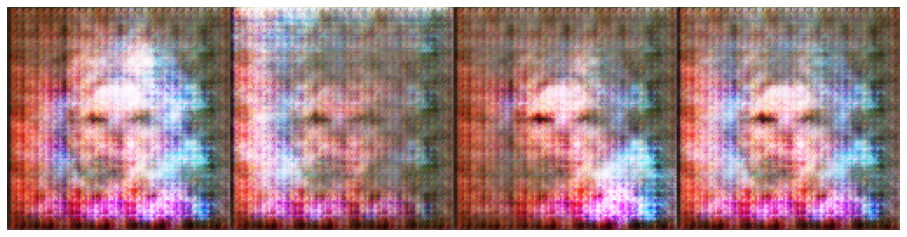

Grid Saved.
2000/3166	 Time: 345.39s	 Gen Loss: 1.54696	 Desc Loss: 0.79412    

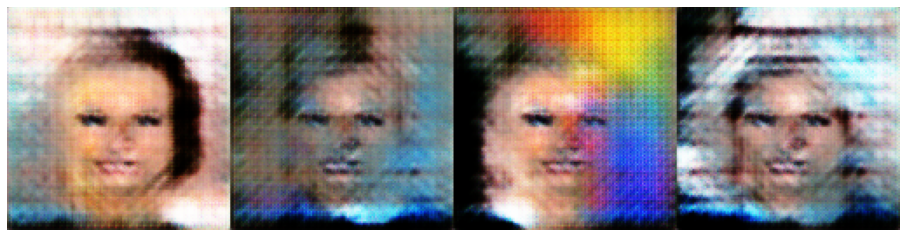

Grid Saved.
3000/3166	 Time: 514.84s	 Gen Loss: 2.88268	 Desc Loss: 0.56996    

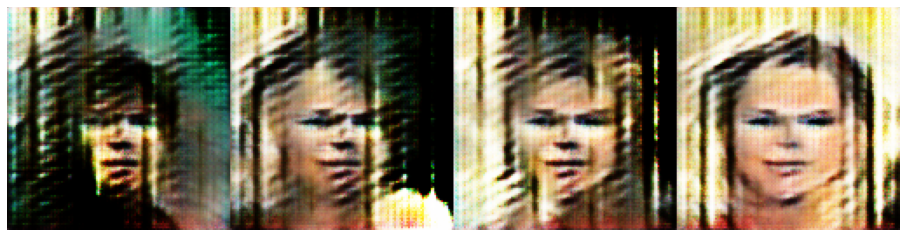

Grid Saved.
3100/3166	 Time: 532.95s	 Gen Loss: 1.22959	 Desc Loss: 0.86043    
Epoch 2 of 50.
0/3166	 Time: 0.41s	 Gen Loss: 1.48114	 Desc Loss: 0.97416    

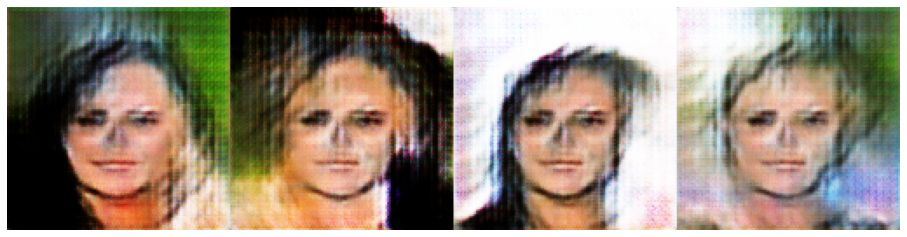

Grid Saved.
Checkpoint saved.
1000/3166	 Time: 171.79s	 Gen Loss: 0.65536	 Desc Loss: 1.30921    

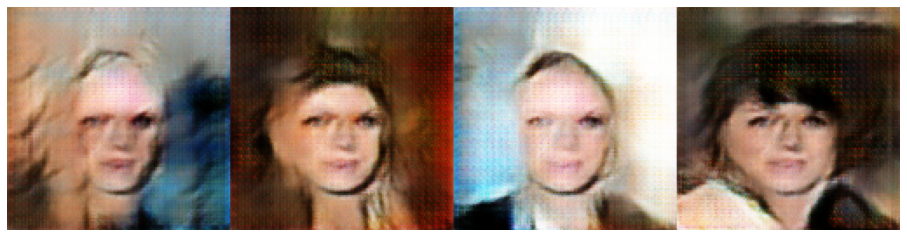

Grid Saved.
2000/3166	 Time: 341.27s	 Gen Loss: 2.31714	 Desc Loss: 0.70671    

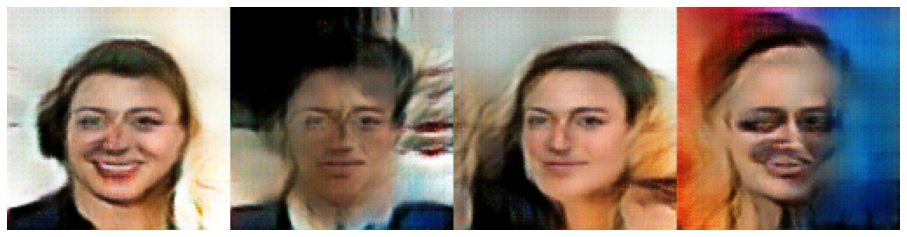

Grid Saved.
3000/3166	 Time: 510.89s	 Gen Loss: 2.82503	 Desc Loss: 0.73679    

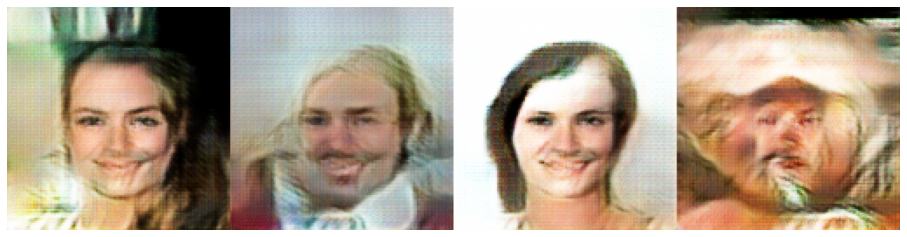

Grid Saved.
3100/3166	 Time: 529.09s	 Gen Loss: 1.65151	 Desc Loss: 0.72009    
Epoch 3 of 50.
0/3166	 Time: 0.44s	 Gen Loss: 1.59888	 Desc Loss: 0.66840    

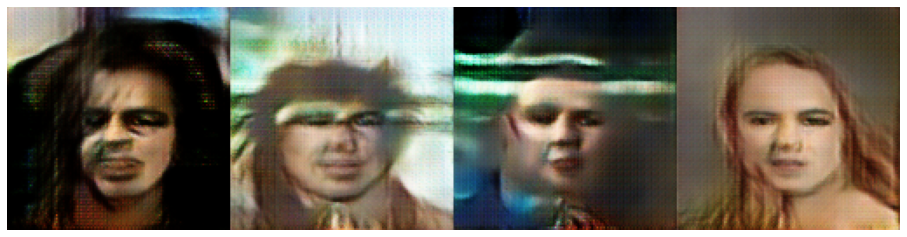

Grid Saved.
Checkpoint saved.
1000/3166	 Time: 170.95s	 Gen Loss: 1.80560	 Desc Loss: 0.63458    

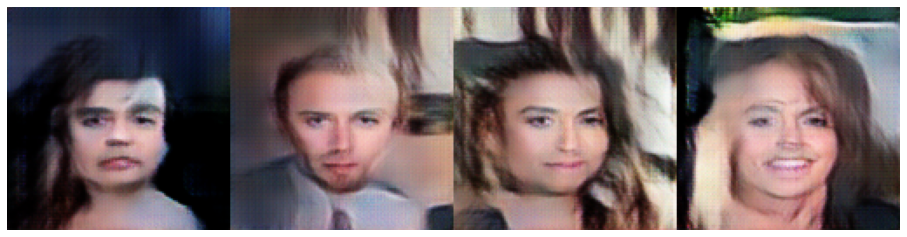

Grid Saved.
2000/3166	 Time: 340.34s	 Gen Loss: 1.69047	 Desc Loss: 0.59617    

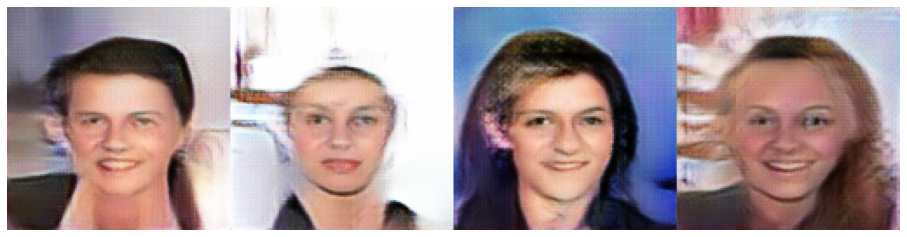

Grid Saved.
3000/3166	 Time: 509.91s	 Gen Loss: 0.53314	 Desc Loss: 1.51079    

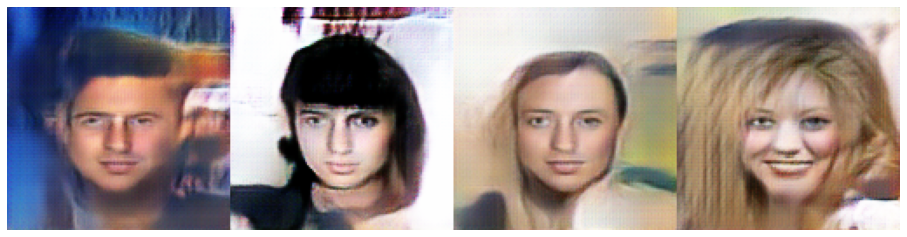

Grid Saved.
3100/3166	 Time: 528.12s	 Gen Loss: 2.45095	 Desc Loss: 0.65989    
Epoch 4 of 50.
0/3166	 Time: 0.45s	 Gen Loss: 1.28715	 Desc Loss: 0.83639    

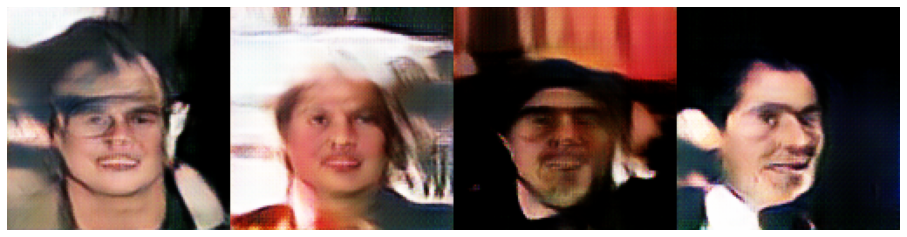

Grid Saved.
Checkpoint saved.
1000/3166	 Time: 170.99s	 Gen Loss: 3.65937	 Desc Loss: 0.61821    

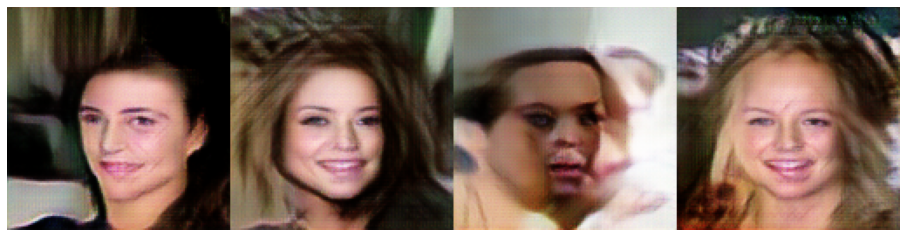

Grid Saved.
2000/3166	 Time: 340.31s	 Gen Loss: 3.16413	 Desc Loss: 0.84285    

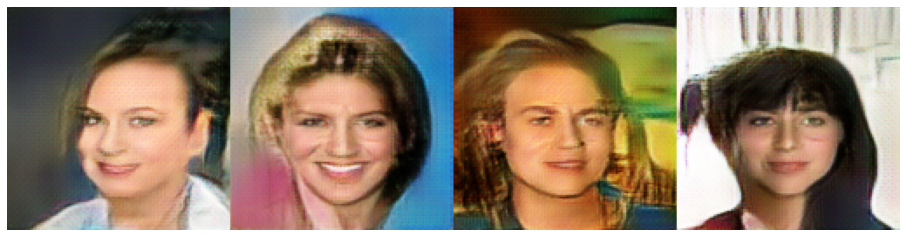

Grid Saved.
3000/3166	 Time: 509.63s	 Gen Loss: 2.10570	 Desc Loss: 0.64591    

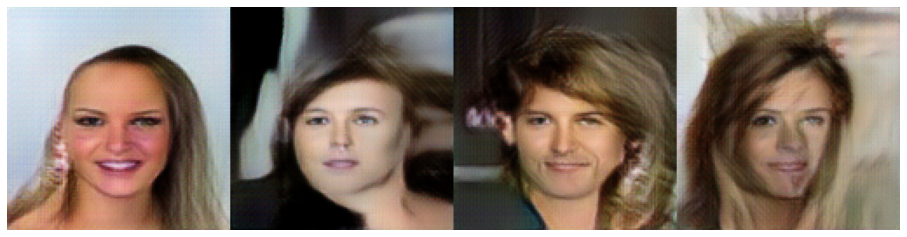

Grid Saved.
3100/3166	 Time: 527.80s	 Gen Loss: 1.64026	 Desc Loss: 0.70936    
Epoch 5 of 50.
0/3166	 Time: 0.42s	 Gen Loss: 1.26944	 Desc Loss: 0.77263    

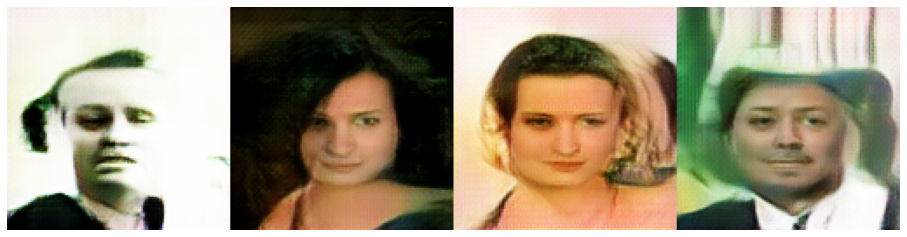

Grid Saved.
Checkpoint saved.


In [ ]:
EPOCHS = 50
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1} of {EPOCHS}.")
    train(dataset)

In [43]:
import glob
import imageio

In [42]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('timelapse/*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)